# Lecture 6 - Sentiment Analysis

In this notebook we will learn how to measure sentiment in text.

Below is the overview of this notebook.
<ol type = 1>
  <li> Measure tweet sentiment using ChatGPT </li>
   <li> Analyze tweet sentiment</li>
   <li> Measure more complex tweet text properties</li>
</ol>

This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture06_SentimentAnalysis.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.

# Clones, imports, and installs

## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")

Cloning into 'social_media_genAI'...
remote: Enumerating objects: 1749, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1749 (delta 31), reused 82 (delta 21), pack-reused 1655 (from 2)
Receiving objects: 100% (1749/1749), 175.73 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (102/102), done.
Updating files: 100% (1483/1483), done.


## Install requirements

In [2]:
pip install -q -r requirements.txt


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 29.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.12.0 requires networkx>=3.2, but you have networkx 3.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.

## Import packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs  #this let's us display tweets properly (emojis, etc.)
import textwrap as tr
from tqdm import tqdm  #progress bar for for loops
from IPython.display import HTML
import json
import textwrap
import plotly.express as px
from sklearn.decomposition import PCA

from scripts.genai import GenAI

#this option makes it so tweets display nicely in a dataframe
pd.set_option("display.max_colwidth", None)

#this code sets the font sizes for plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'figure.figsize':(8,6),
                     'axes.grid':True})



## OpenAI API Key

You will need to input your OpenAI API key.  

1.  First you need to create an account with OpenAI here: https://auth0.openai.com/u/signup?state=hKFo2SBWS3JUVEdmQmdzZXo5ckhpY3R5NEFlc2NPWWc3WHhvRqFur3VuaXZlcnNhbC1sb2dpbqN0aWTZIG9kTDB4LV83aEdnN3pRU3VUYnVZemlnZkFURFo2RDhno2NpZNkgRFJpdnNubTJNdTQyVDNLT3BxZHR3QjNOWXZpSFl6d0Q

2. Once you have an account, copy your API key from here: https://beta.openai.com/account/api-keys

3. Finally, paste your key below:  `OPENAI_API_KEY = "your OpenAI API key"`

In [4]:
OPENAI_API_KEY = ""


## Connect to ChatGPT

You will need to paste the API key given to you in the OPENAI_API_KEY variable as a string.  Then run this cell to connect to the OpenAI API using the GenAI package provided in the GitHub repository.

In [5]:
# Initialize GenAI
jarvis = GenAI(OPENAI_API_KEY)

text = "Who are you?"
instructions = "You are a helpful assistant."
response = jarvis.generate_text(text, instructions)
print(f"Human:{text}\nAI:{response}")

Human:Who are you?
AI:I am an AI language model created by OpenAI, designed to assist users by providing information, answering questions, and engaging in conversation on a wide range of topics. How can I help you today?


# Measuring Sentiment with ChatGPT

We will use ChatGPT to measure the sentiment of some tweets

## Instructions

Write down instructions to give the AI for measuring sentiment. For now, just tell it to return the numerical sentiment score.

In [6]:
instructions_sentiment = '''Give the sentiment of this
tweet on a scale of 0 to 100, 0 being very
negative and 100 being very positive.
Return only the number. '''



## Example tweets

We make a list `texts` that has some example tweets for testing out the AI sentiment classifier.  Feel free to add anything  you want to this list.

In [7]:
texts = ["This class is kinda boring, but informative",
        "This class is awesome",
        "this class is stupid",
        "this class is dope",
       "this class slaps",
       "this class is fun",
       "this class is fun!",
       "this class is :(",
       "this class is :)"]

## Measure sentiment

We use a for loop to go through all the tweets, measure their sentiment, and then print out the sentiment score and tweet text.  We will also use a progress bar to see how long it will take with the `tqdm` package.

In [8]:
# prompt: go through the text in the list texts and measure their sentiment with the jarvis.generate_text functin and print out sentimet and text.  add a tqdm progress bar to the for loop


for text in tqdm(texts):
  try:
    response = jarvis.generate_text(text, instructions_sentiment)
    sentiment = int(response)
    print(f"Sentiment: {sentiment}, Text: {text}")
  except Exception as e:
    print(f"Error with {text}\nError:{e}")

 11%|█         | 1/9 [00:01<00:10,  1.33s/it]

Sentiment: 60, Text: This class is kinda boring, but informative


 22%|██▏       | 2/9 [00:02<00:10,  1.51s/it]

Sentiment: 90, Text: This class is awesome


 33%|███▎      | 3/9 [00:05<00:11,  1.90s/it]

Sentiment: 20, Text: this class is stupid


 44%|████▍     | 4/9 [00:06<00:08,  1.63s/it]

Sentiment: 90, Text: this class is dope


 56%|█████▌    | 5/9 [00:08<00:06,  1.60s/it]

Sentiment: 90, Text: this class slaps


 67%|██████▋   | 6/9 [00:08<00:03,  1.22s/it]

Sentiment: 85, Text: this class is fun


 78%|███████▊  | 7/9 [00:09<00:02,  1.28s/it]

Sentiment: 90, Text: this class is fun!


 89%|████████▉ | 8/9 [00:10<00:01,  1.04s/it]

Sentiment: 20, Text: this class is :(


100%|██████████| 9/9 [00:11<00:00,  1.31s/it]

Sentiment: 90, Text: this class is :)


# Measuring Real Tweet Sentiment

## Load User Tweets

We can load the user tweets with the `pd.read_csv` function into a dataframe called `df`.

In [9]:
#filename of csv file
fname = 'data/TwExportly/TwExportly_yale_tweets_2024_03_02.csv'
df = pd.read_csv(fname)
print(f"Number of tweets: {len(df)}")


Number of tweets: 980


## Calculate sentiment with a for loop
**Don't need to run this in class because it takes a while**.

We use a for loop iterating over the rows in `df` to calculate the sentiment of each tweet.  We store the sentiment in the list `sentiments`.  We then add the sentiment to a column in `df`.   The speed of this code is 100 tweets/minute.






In [ ]:
%%time
#DONT RUN THIS CODE UNLESS YOU HAVE 10 MINUTES FREE!!!!
sentiments = []
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment", unit="row"):
  try:
    sentiment = jarvis.generate_text(row.text,instructions_sentiment)  #calculate sentiment and embedding of tweet
    sentiment = float(sentiment)  #convert sentiment to float
  except:
    sentiment = None  #if there is an error, set sentiment to 0

  sentiments.append(sentiment)  #append sentiment of tweet to Sentiment list

df['sentiment'] = sentiments  #add sentiment column to dataframe of tweets


Processing Sentiment: 100%|██████████| 980/980 [09:16<00:00,  1.76row/s]

CPU times: user 10.9 s, sys: 631 ms, total: 11.5 s
Wall time: 9min 16s


## Look at some tweets + sentiment

Lets look at the `sentiment` and `text` columns of a random sample of tweets from `df`, just to make sure things worked ok.

In [ ]:
cols = ['sentiment','text']
df[cols].sample(3)

## Save sentiments


You can save the resulting dataframe to a file with the `pd.to_csv` function.  We will set `fname_sentiment` equal to the path and filename where you want to save the data.  

Once the file is save, download it using the file menu on the left.  

Later on if you want to analyze this file, you can upload it to the `"social_media_genai/main/data"` folder.

In [ ]:
fname_sentiment = "data/lec_04_tweets_sentiment_student.csv"
df.to_csv(fname_sentiment)
print(f"Saved file to {fname_sentiment}")

Saved file to data/lec_04_tweets_sentiment.csv


# Analyze Tweet Sentiment

### Load Tweets and Sentiment

Once we save the tweet sentiments, the next time we run the notebook we can just load this data instead of recalculating the sentiment.  The sentiment is in the file `"data/lec_06_tweets_sentiment_embedding.csv"`.

In [10]:
# prompt: load "data/lec_06_tweets_sentiment_embedding.csv" into df
fname_sentiment = "data/lec_04_tweets_sentiment.csv"
df = pd.read_csv(fname_sentiment)
cols = ['sentiment','text']
df[cols].sample(3)

,sentiment,text
0,60.0,"Jason Stanley, a Yale philosopher and propaganda scholar, discusses his new book about how political messages can be embedded in seemingly straightforward statements — and how politicians often harness this phenomenon “in devious ways.” https://t.co/f0Fizm7KhA #Yale https://t.co/picZgwj6AY"
321,60.0,The transition from mentored to independent research is an important career junction for biomedical researchers. A new Yale-led study finds that women researchers in the United States reach that point at lower rates than men. @YaleMed #Yale https://t.co/RXvGGoGvBe
725,75.0,"In 2017, Pulitzer Prize-winner Jake Halpern ’97 led a Yale class on a reporting trip to Greece. In a migrant camp there, they met a young man who became a friend — and whose cause would unite Yalies across Europe. @yalealumnimag #Yale https://t.co/gzNAEVV4mI"


## Sentiment Statistics

We can use `describe` to see some basic statistics of the `sentiment`.

In [12]:
# prompt: describe sentiment of df

# Assuming df is already loaded as in the provided code.
# If not, load it first using:
# fname_sentiment = "data/lec_04_tweets_sentiment.csv"
# df = pd.read_csv(fname_sentiment)

df['sentiment'].describe()

,sentiment
count,980.000000
mean,75.826531
std,14.168493
min,20.000000
25%,70.000000
50%,80.000000
75%,85.000000
max,100.000000


## Sentiment Distribution

We can make histograms of the tweet sentiment.
We use the `kdeplot` function to make a kernel density estimate of the histogram (it looks nicer).

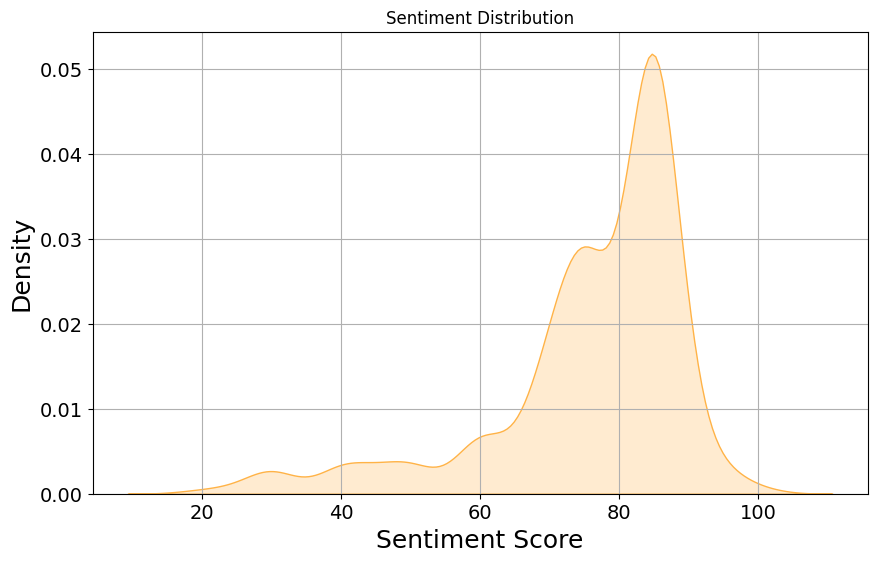

In [13]:
# prompt: make a kdeplot of the sentiment of df and fill it in a pretty light orange


# Assuming 'df' is your DataFrame and 'sentiment' is the column with sentiment scores.
# Check if 'sentiment' column exists, handle potential errors gracefully
if 'sentiment' in df.columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    sns.kdeplot(df['sentiment'], color="#FFB347", fill=True)  # Light orange fill
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.show()
else:
    print("Error: 'sentiment' column not found in the DataFrame.")

## Look at Tweets with Extreme Sentiment

We can select tweets of each user with very high or very low sentiment and print them out.  We do this by using `sort_values` to sort the user's tweets by sentiment.  We set `ascending = True` to get the most postive tweets, and set `ascending = False` to get the most negative tweets.  We set `ndisplay` equal to the number of tweets we want to print.

To show all the funny Twitter characters, we need to use the `decode` function in the `codecs` module.



In [14]:
# prompt: set ndisplay = 3, then print out the ndisplay text with highest sentiment, and ndisplay text wiht lowest sentiment.  print sentimet: text.  use textwrap so tweets are easier to read. put new line btween tweets.

ndisplay = 3

# Assuming df is already loaded as in the provided code.
# If not, load it first using:
# fname_sentiment = "data/lec_04_tweets_sentiment.csv"
# df = pd.read_csv(fname_sentiment)

if 'sentiment' in df.columns:
    # Sort by sentiment and get the top and bottom ndisplay tweets
    top_tweets = df.sort_values(by='sentiment', ascending=False).head(ndisplay)
    bottom_tweets = df.sort_values(by='sentiment', ascending=True).head(ndisplay)

    print(f"Top {ndisplay} tweets by sentiment:")
    for _, row in top_tweets.iterrows():
        print(f"Sentiment: {row['sentiment']}")
        print("\n".join(tr.wrap(codecs.decode(row['text'], 'unicode_escape'), width=70)))
        print("\n")

    print(f"\nBottom {ndisplay} tweets by sentiment:")
    for _, row in bottom_tweets.iterrows():
        print(f"Sentiment: {row['sentiment']}")
        print("\n".join(tr.wrap(codecs.decode(row['text'], 'unicode_escape'), width=70)))
        print("\n")
else:
    print("Error: 'sentiment' column not found in the DataFrame.")

Top 3 tweets by sentiment:
Sentiment: 100.0
Congratulations to Yale historian Beverly Gage on winning the 2023
Pulitzer Prize in Biography!


Sentiment: 100.0
IVY LEAGUE CHAMPIONS for the third time in the last four seasons ð
#ThisIsYale https://t.co/ZoBBk9B9PU


Sentiment: 100.0
ð Cheers to the Class of 2023!   #Yale2023 #Yale #YaleAlumni
#YaleUniversity @Yale https://t.co/42heDviuEi



Bottom 3 tweets by sentiment:
Sentiment: 20.0
Extraction of petroleum from Canadaâs Athabasca oil sands generates
as much as 64 times more air pollution than had been estimated, a Yale
co-led study found. That's roughly the sum of all other human-made
emissions in Canada combined: https://t.co/O6ZrhKMP5a @YaleSEAS #Yale
https://t.co/9tXaeSdXz1


Sentiment: 20.0
The intense pain of a cluster headache attack is sometimes described
as being worse than passing a kidney stoneâor even childbirth.
@YaleMedicine #Yale https://t.co/0GeA0qG8DH


Sentiment: 20.0
In a novel data-based analysis, Yale econ

## Engagement

We can define the engagement of a tweet as its `favorite_count` divided by its `view_count`.  Do this and add it as a colummn `engagement` to `df`.

In [15]:
df['engagement'] = df.favorite_count/df.view_count

## Most and Least Engaging Tweets

In [18]:
# prompt: ndisplay = 3, print out the most and least engagement tweets, print engagement: text.

ndisplay = 3

# Assuming df is already loaded as in the provided code.
# If not, load it first using:
# fname_sentiment = "data/lec_04_tweets_sentiment.csv"
# df = pd.read_csv(fname_sentiment)

if 'engagement' in df.columns and 'text' in df.columns:
    # Sort by engagement and get the top and bottom ndisplay tweets
    top_tweets = df.sort_values(by='engagement', ascending=False).head(ndisplay)
    bottom_tweets = df.sort_values(by='engagement', ascending=True).head(ndisplay)

    print(f"Top {ndisplay} tweets by engagement:")
    for _, row in top_tweets.iterrows():
        print(f"Engagement: {row['engagement']}: {row['text']}")
        print("\n")

    print(f"\nBottom {ndisplay} tweets by engagement:")
    for _, row in bottom_tweets.iterrows():
        print(f"Engagement: {row['engagement']}: {row['text']}")
        print("\n")
else:
    print("Error: 'engagement' or 'text' column not found in the DataFrame.")

Top 3 tweets by engagement:
Engagement: 0.01992772315506951: Bobbi, 9, was the subject of alleged racial profiling while working to eradicate the invasive spotted lanternfly in Oct. Last week, she was honored by @Yale. The lanternflies she donated to @yalepeabody will be forever associated with her name.

More: https://t.co/gWKQDzD7el https://t.co/uxuLQoRSOv


Engagement: 0.01755495808951447: Sure is beautiful, isn’t it? ❄️ #Yale https://t.co/6O2oFet6OR


Engagement: 0.014658098057621489: Congratulations Class of 2023! I'm so proud of you! 
#Classof2023 #graduation #yale https://t.co/MBkH34NFap



Bottom 3 tweets by engagement:
Engagement: 0.00048658840703120245: Clarissa Ward ‘02, @CNN's chief international correspondent, was back on campus for an in-depth conversation about her nearly two decades of reporting from the front lines. Read more here: https://t.co/bJKhWZsIjn #Yale @ISSYale @JacksonYale @clarissaward @Poynter https://t.co/iiij88FUB7


Engagement: 0.0006981918015715233: We 

## Plot of Engagement and Retweet Count vs Sentiment

Make bar plots of the `engagement` and `retweet_count` vs high and low sentiment.  To do this, add a column `high_sentiment` to `df` that is True or False if `sentiment` is above or below 50.

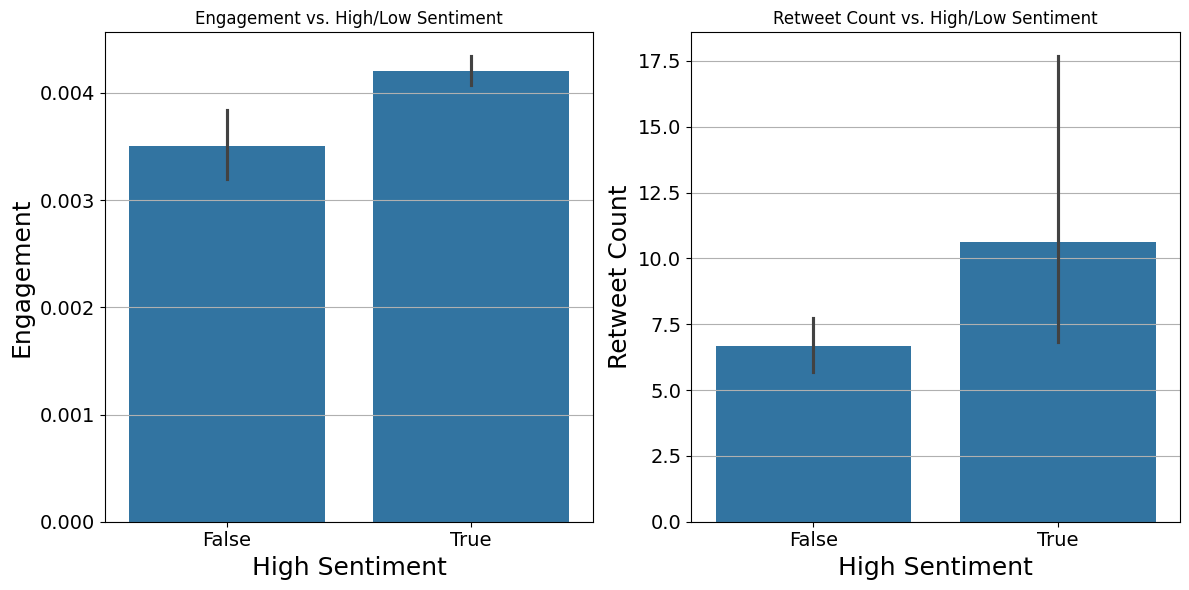

In [16]:
# prompt: Make bar plots of the `engagement` and `retweet_count` vs high and low sentiment.  To do this, add a column `high_sentiment` to `df` that is True or False if `sentiment` is above or below 50.

df['high_sentiment'] = df['sentiment'] > 50

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='high_sentiment', y='engagement', data=df)
plt.title('Engagement vs. High/Low Sentiment')
plt.xlabel('High Sentiment')
plt.ylabel('Engagement')

plt.subplot(1, 2, 2)
sns.barplot(x='high_sentiment', y='retweet_count', data=df)
plt.title('Retweet Count vs. High/Low Sentiment')
plt.xlabel('High Sentiment')
plt.ylabel('Retweet Count')

plt.tight_layout()
plt.show()

## Correlation of sentiment with tweet metrics

Use the `.corr` method to look at the correlation of `sentiment` with other tweet metrics, like `engagement` or `retweet_count`.

In [19]:
cols = ['sentiment','engagement','favorite_count','retweet_count','view_count']
df[cols].corr()

,sentiment,engagement,favorite_count,retweet_count,view_count
sentiment,1.000000,0.206275,0.014273,0.006612,0.029370
engagement,0.206275,1.000000,0.290995,0.272765,0.216254
favorite_count,0.014273,0.290995,1.000000,0.998288,0.900304
retweet_count,0.006612,0.272765,0.998288,1.000000,0.891899
view_count,0.029370,0.216254,0.900304,0.891899,1.000000


# Visualize Tweet Embeddings

Now we will visulize the transformer embeddings using the UMAP algorithm to see how the sentiment is distributed.  UMAP is similar to t-SNE.  The embedding has been pre-calculated for you to save time.

## Load tweets and sentiment

In [39]:
fname_sentiment = "data/lec_04_tweets_sentiment.csv"
df = pd.read_csv(fname_sentiment)
cols = ['sentiment','text']
df[cols].sample(3)

,sentiment,text
450,85.0,"A new alert system was found to be highly effective in getting physicians to discontinue medications in a more timely way, preventing injurious side effects. @YaleMed #Yale https://t.co/W6ZyF9Se1L"
970,75.0,"Join us tomorrow (1/24) @ 4pm for the rescheduled lecture ""A New Age of Exploration in Antarctic Biodiversity,"" a live, virtual presentation by @Yale Ph.D. candidate Elyse Parker (@chantal_elyse)\n\nInfo and registration here: \nhttps://t.co/UMWNiS9Cmo https://t.co/hHQ4KAcQNE"
559,75.0,May the course be with you…⛳\n\n📰https://t.co/STNmedUXii | #ThisIsYale https://t.co/XybReQdWDx


## Compute Tweet Embeddings

**Don't need to run this in class because it takes a while**.

We will use the `get_embedding` function in the `GenAI` class to compute the embeddings.  This function uses the OpenAI embeddings function, which is a big transformer.  

In [40]:
#ONLY RUN THIS IF YOU HAVE 10 MINUTES FREE!!!
embeddings = []
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Embeddings", unit="row"):
  embedding = jarvis.get_embedding(row.text)
  embeddings.append(embedding)

Processing Embeddings: 100%|██████████| 980/980 [08:15<00:00,  1.98row/s]


## Project embeddings into two dimensions with PCA

We can use PCA (Principle Component Analysis) to project the high dimensional embeddings into two dimensions so we can visualize them and understand the AI's geometry.  We will save these x and y coordinates in columns `pca_x` and `pca_y` in `df`.

This code only works if you ran the previous cell to compute the embeddings.  If you didnt, dont worry, they were pre-computed before lecture for you.

In [41]:
# prompt: compute the PCA 2 d projection of the array embeddings and then add columns pca_x, pca_y to df

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'embeddings' is a list of lists (or a numpy array) where each inner list represents an embedding.
# Assuming 'df' is your DataFrame.

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_array)

# Add the PCA components as new columns to the DataFrame
df['pca_x'] = pca_result[:, 0]
df['pca_y'] = pca_result[:, 1]

## Project embeddings into two dimensions with t-SNE

We can use t-SNE (t-distributed Stochastic Neighbor Embedding) to project the high dimensional embeddings into two dimensions so we can visualize them and understand the AI's geometry.  t-SNE takes you to two dimensions in a different way than PCA.  It is slower, but some people like the way it looks.   We embed, you decide.  

We will save these t-SNE x and y coordinates in columns `tsne_x` and `tsne_y` in `df`.

This code only works if you ran the previous cell to compute the embeddings.  If you didnt, dont worry, they were pre-computed before lecture for you.

In [42]:
# prompt: compute t-sne embedding of embeddings and add cols tsna_x, tsne_y

from sklearn.manifold import TSNE

# Assuming 'embeddings' is a list of lists (or a numpy array) where each inner list represents an embedding.
# Assuming 'df' is your DataFrame.

# Convert the list of embeddings to a NumPy array if it's not already
embeddings_array = np.array(embeddings)

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2, random_state=0)  # Initialize t-SNE with random_state for reproducibility
tsne_result = tsne.fit_transform(embeddings_array)

# Add the t-SNE components as new columns to the DataFrame
df['tsna_x'] = tsne_result[:, 0]
df['tsne_y'] = tsne_result[:, 1]

## Save Low Dimensional Embeddings

This code will save `df` to  CSV file after you have the embeddings computed to save you time later.

In [43]:
fname_sentiment = "data/lec_04_tweets_sentiment.csv"
df.to_csv(fname_sentiment)
print(f"Saved file to {fname_sentiment}")

Saved file to data/lec_04_tweets_sentiment.csv


In [ ]:
fname_sentiment = "data/lec_04_tweets_sentiment_student.csv"
df.to_csv(fname_sentiment)
print(f"Saved file to {fname_sentiment}")

## Scatter Plot of Transformer Tweet Embeddings

We can make a scatter plot of the  transformer embeddings of the tweets.  We will color the tweets by their sentiment by choosing a color palette.  A complete list can be found here: https://seaborn.pydata.org/tutorial/color_palettes.html

We will make the plots with the PCA coordinates and again with the t-SNE coordinates.


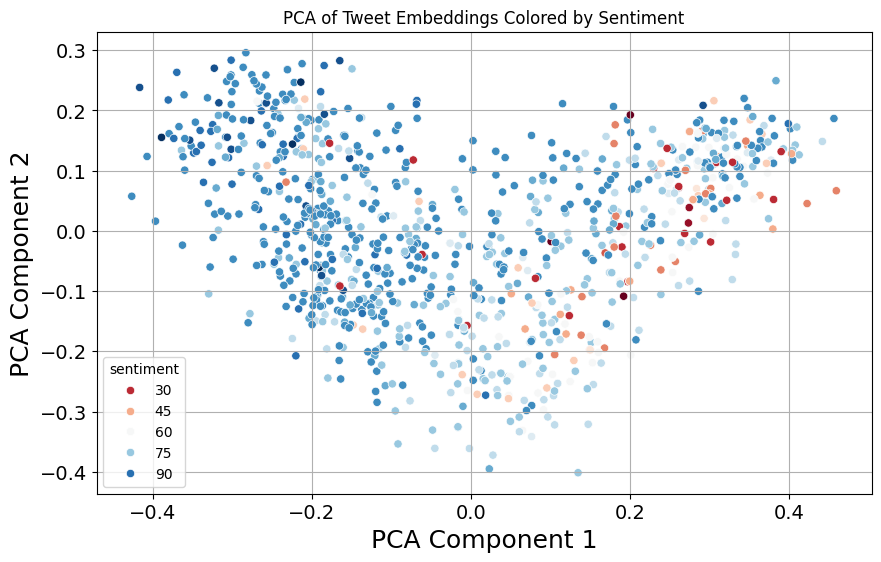

In [44]:
# prompt: scatter plot pca_x vs pca_y, color markers by sentiment, 0 = blue 100 = red.
df = pd.read_csv("data/lec_04_tweets_sentiment.csv")

# Assuming 'df' is your DataFrame and it contains 'pca_x', 'pca_y', and 'sentiment' columns.
# Check if required columns exist, handle potential errors gracefully
required_cols = ['pca_x', 'pca_y', 'sentiment']
if all(col in df.columns for col in required_cols):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='pca_x', y='pca_y',
                    hue='sentiment',
                    palette="RdBu",
                    data=df)
    plt.title('PCA of Tweet Embeddings Colored by Sentiment')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()
else:
    print("Error: One or more required columns ('pca_x', 'pca_y', 'sentiment') not found in the DataFrame.")

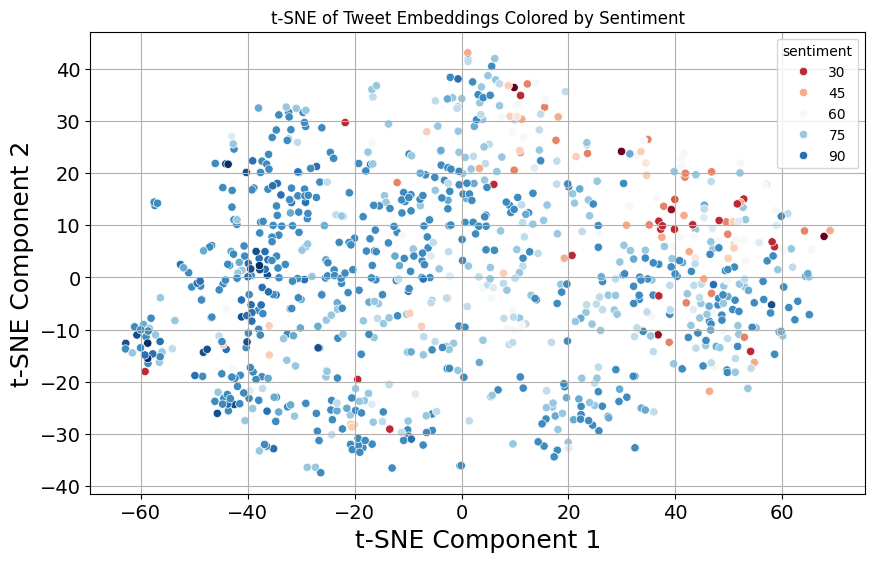

In [45]:
# prompt: # prompt: scatter plot tsne_x vs tsne_y, color markers by sentiment, 0 = blue 100 = red.

df = pd.read_csv("data/lec_04_tweets_sentiment.csv")

# Assuming 'df' is your DataFrame and it contains 'tsna_x', 'tsne_y', and 'sentiment' columns.
# Check if required columns exist, handle potential errors gracefully
required_cols = ['tsna_x', 'tsne_y', 'sentiment']
if all(col in df.columns for col in required_cols):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='tsna_x', y='tsne_y',
                    hue='sentiment',
                    palette="RdBu", data=df)
    plt.title('t-SNE of Tweet Embeddings Colored by Sentiment')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
else:
    print("Error: One or more required columns ('tsna_x', 'tsne_y', 'sentiment') not found in the DataFrame.")

# More Complex Sentiments

Now we will try some more complex types of sentiment from the tweets.

## Load Tweets

We will load the tweets, but only use a sample of them for this analysis, just to save time.

In [46]:
fname_sentiment = "data/lec_04_tweets_sentiment.csv"
df = pd.read_csv(fname_sentiment)

#keep only last 10 rows
df = df.tail(10)
print(f"Number of tweets: {len(df)}")

Number of tweets: 10


## Choosing a type of sentiment

We can ask the AI what kind of complex sentiment we can measure.  Display the output as HTML so its easier to read.  

In [28]:
prompt = '''What are some complex multidimensional
measures of sentiment i can do for a tweet?
Return answer as pretty html with dark backgroun
and white font '''
response_html = jarvis.generate_text(prompt)


In [29]:
# prompt: dispaly html string response_html

from IPython.display import HTML
HTML(response_html)


## Choose a complex sentiment measure

In `instructions_sentiment_complex` tell the AI what kind of sentiment you want it to measure.  Also tell it to format it as a JSON object (this is a dictionary with keys and values) and tell it what the keys should be.

In [47]:
instructions_sentiment_complex = '''Measure the following
properties of the given tweet:
joy, sadness, anger, fear, disgust,
anxiety, envy, embarassment, ennui
(all 0 to 100).
Return asnswer as JSON with format:
{
  'joy'<joy>,
  'anger'<anger>,
  'sadness'<sadness>,
  'fear'<fear>,
  'disgust'<disgust>,
  'anxiety'<anxiety>,
  'envy'<envy>,
  'ennui'<ennui>,
}
'''

## Test on a sample text

In [48]:
text = '''Im so stressed about recruiting.
My friends all have offers and Im still struggling
to get an interview.'''
sentiment = jarvis.generate_text(text,
                    instructions_sentiment_complex,
                    output_type = 'json_object')
sentiment_json = json.loads(sentiment)
sentiment_json

{'joy': 20,
 'anger': 10,
 'sadness': 70,
 'fear': 60,
 'disgust': 15,
 'anxiety': 85,
 'envy': 75,
 'ennui': 40}

## Measure complex sentiment of tweets

Now we will compute the complex sentitment of the sample of tweets we have in `df`. After we compute the sentiment, we will put it in a dataframe `df_sentiment` with one column for each sentiment type.  Then we will concatenate `df` and `df_sentiment` so we have all the data in one dataframe.

In [49]:
%%time
sentiments = []
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment", unit="row"):
  try:
    sentiment = jarvis.generate_text(row.text,
                  instructions_sentiment_complex,
                  output_type = 'json_object')
    sentiment_json = json.loads(sentiment)
  except:
    sentiment = None  #if there is an error, set sentiment to 0
  sentiments.append(sentiment_json)  #append sentiment of tweet to Sentiment list

df_sentiment = pd.DataFrame(sentiments)  #add sentiment column to dataframe of tweets
df_sentiment = df_sentiment.reset_index(drop=True)


Processing Sentiment: 100%|██████████| 10/10 [00:24<00:00,  2.45s/row]

CPU times: user 199 ms, sys: 12.2 ms, total: 212 ms
Wall time: 24.5 s


In [50]:
# prompt: concatenate df and df_sentiment into one dataframe called df1.  they have diferent indices, so reset that.

import pandas as pd

# Assuming df and df_sentiment are already defined as in the provided code.
# If not, load them first.

# Concatenate df and df_sentiment, resetting indices
df1 = pd.concat([df.reset_index(drop=True), df_sentiment.reset_index(drop=True)], axis=1)
df1.tail(1)

,Unnamed: 0.1,Unnamed: 0,tweet_id,text,language,type,bookmark_count,favorite_count,retweet_count,reply_count,...,tsna_x,tsne_y,joy,anger,sadness,fear,disgust,anxiety,envy,ennui
9,979,979,1616788705544380419,"It may feel like history is repeating itself with yet another strain of the SARS-CoV-2 virus driving up cases of COVID-19. The latest is called XBB.1.5, and it’s another descendent of the Omicron variant. @YaleMedicine #Yale\nhttps://t.co/sY39iDJ1Tq",en,Tweet,1,16,11,0,...,51.57882,14.114983,20,30,40,50,25,50,10,15


## Interactive Scatterplot

One cool thing we can do is make an interactive scatterplot of the tweets.  We color them by one of the sentiments and make it so when we hover over a marker the tweet text and sentiments pop up.   We will need to wrap the text so its easy to read in the pop-up.  This code is tricky, so let the AI handle it. The prompt is in the comment below.

You can save this plot to an HTML file so you can view on on a web browser.

In [52]:
# prompt: # prompt: make an interactive scatter plot of pca_x vs pca_y, color markers by column col_color = 'joy', then hover text on marker = text, joy, sadness, fear, disgust, anxiety, envy, ennui
# markery size = 20
marker_size=20
df1['wrapped_text'] = df1['text'].apply(lambda x: "<br>".join(textwrap.wrap(x, width=30)))


# Assuming df1 is your DataFrame and it contains 'pca_x', 'pca_y', 'joy', 'sadness', 'fear', 'disgust', 'anxiety', 'envy', 'ennui' columns.
# Check if required columns exist, handle potential errors gracefully
required_cols = ['pca_x', 'pca_y', 'joy', 'sadness', 'fear', 'disgust', 'anxiety', 'envy', 'ennui', 'wrapped_text']
if all(col in df1.columns for col in required_cols):
  fig = px.scatter(df1, x='pca_x', y='pca_y', color='joy',
                   hover_data=['wrapped_text', 'joy', 'sadness', 'fear', 'disgust', 'anxiety', 'envy', 'ennui'],
                   title='Interactive Scatter Plot of PCA Components',
                   labels={'pca_x': 'PCA Component 1', 'pca_y': 'PCA Component 2', 'joy': 'Joy Score'},
                   width=800, height=600)

  fig.update_traces(marker=dict(size=marker_size))
  fig.write_html("scatter_tweet_sentiment_complex.html") # save figure to html

  fig.show()
else:
  print("Error: One or more required columns are missing in the DataFrame.")

# User Analysis

Now we will feed all the tweets to the AI at once and build a behavioral profile of the user.

## Load data

In [53]:
fname = "data/TwExportly/TwExportly_elonmusk_tweets_2024_02_10.csv"
df = pd.read_csv(fname)


print(f"Number of tweets: {len(df)}")

Number of tweets: 1000


## Convert tweets into a single string

In [55]:
# prompt: put all the string in df['text'] into a single string wiht format "Tweet:<text>\n" and call the string tweets_str

tweets_str = ""
for text in df['text']:
  tweets_str += f"Tweet:{text}\n"
nwords = len(tweets_str.split())
print(f"Number of words in combined tweets: {nwords}")


Number of words in combined tweets: 10180


## Build behavioral profile

`instructions_profile` tells the AI how to build the behavioral profile.  To make it easy to read, you can have it return an HTML table.

In [56]:
instructions_profile = ''' You will be given the tweets
of a user.  Read them, and then build a behavioral profile
for them with the following features:
  joy, sadness, anger, fear, disgust,
  anxiety, envy, embarassment, ennui (all 0 to 100).
  Return asnswer as an HTML table, with columns
  Feature, Score, Reason.
  Score = avg score for feature based on tweets,
  Reason = reason for the score.
  '''

response_html = jarvis.generate_text(tweets_str,instructions_profile)
HTML(response_html)

Feature,Score,Reason
Joy,75,"The user frequently expresses amusement and pleasure, as seen from the high number of laughing emojis and light-hearted responses in the tweets."
Sadness,25,"Occasional expressions of concern or regret regarding social issues are present, but they are overshadowed by the overall positive tone in other interactions."
Anger,65,"Many tweets show frustration about political situations and societal issues, reflecting a significant level of indignation towards current events."
Fear,30,Concern about political outcomes and societal changes implies a mild level of fear regarding the future.
Disgust,40,"Some tweets exhibit a sense of disgust towards various social topics, particularly those mentioning racism or political cheating."
Anxiety,35,"A few tweets reflect invasive thoughts on political matters and societal issues, indicating mild anxiety."
Envy,15,"Very little indication of envy, as most tweets focus more on sharing successful developments rather than comparison with others."
Embarrassment,20,Minimal embarrassment is expressed; interactions are mostly assertive and assertive rather than self-deprecating.
Ennui,15,Limited signs of boredom; the tweets reflect more engagement with current events rather than dullness.


## Radar Plot

We can make a radar plot to visualize the user's behavioral profile.  We just need to get the numbers into a dataframe we will call `df_sentiment`.

In [66]:
instructions_profile_json = ''' You will be given the tweets
of a user.  Read them, and then build a behavioral profile
for them with the following features:
  joy, sadness, anger, fear, disgust,
  anxiety, envy, embarassment, ennui (all 0 to 100).
  Return asnswer as JSON with format:
{
  'joy'<joy>,
  'anger'<anger>,
  'sadness'<sadness>,
  'fear'<fear>,
  'disgust'<disgust>,
  'anxiety'<anxiety>,
  'envy'<envy>,
  'ennui'<ennui>,
}
  '''

sentiment = jarvis.generate_text(tweets_str,
                    instructions_profile_json,
                    output_type = 'json_object')
sentiment_json = json.loads(sentiment)
df_sentiment = pd.DataFrame(sentiment_json, index=[0])
df_sentiment.head()

,joy,anger,sadness,fear,disgust,anxiety,envy,ennui
0,70,45,30,40,32,38,20,25


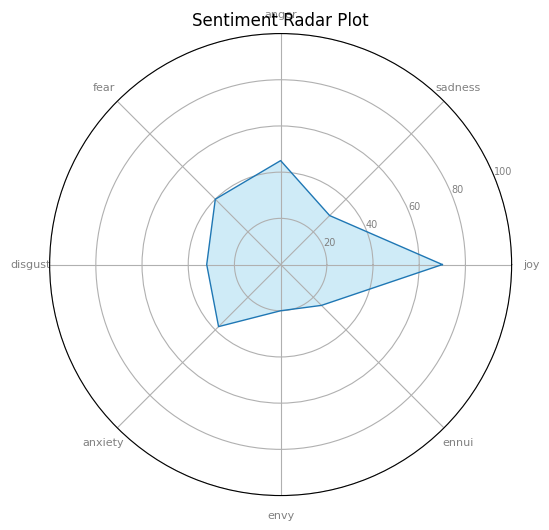

In [67]:
# prompt: df_sentiment has columns joy, sadness, anger, fear, disgust, anxiety, envy,  and ennui.  make a radar plot of these values (they range from 0 to 100).

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_sentiment is your DataFrame and it contains the specified columns.
# Check if required columns exist, handle potential errors gracefully.
required_cols = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'anxiety', 'envy', 'ennui']
if all(col in df_sentiment.columns for col in required_cols):
    categories = required_cols
    values = df_sentiment.loc[0, categories].values.flatten().tolist()  # Get values for the radar plot

    # Number of variables
    N = len(categories)

    # Angles for the radar plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the circle

    # Values for the radar plot
    values += values[:1]  # Close the circle

    # Plot the radar chart
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    plt.yticks([20, 40, 60, 80, 100], ['20', '40', '60', '80', '100'], color="grey", size=7)
    plt.ylim(0, 100)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'skyblue', alpha=0.4)

    plt.title('Sentiment Radar Plot')  # Add a title
    plt.show()
else:
    print("Error: One or more required columns are missing in the DataFrame.")

# User Evolution

Now lets see how a user's behavioral profile evolved over time.

## Load Tweets

We will load the old and new tweets into dataframes `df_old` and `df_new`.

In [7]:
fname = "data/TwExportly/TwExportly_elonmusk_tweets_2024_02_10.csv"
df_old = pd.read_csv(fname)

fname = "data/TwExportly/TwExportly_elonmusk_tweets_2025_01_23.csv"
df_new = pd.read_csv(fname)


print(f"Number of old tweets: {len(df_old)}")
print(f"Number of new tweets: {len(df_new)}")

Number of old tweets: 1000
Number of new tweets: 1004


## Check the date range of the tweets

In [8]:
# prompt: print out the range of dates of the tweets in df_old and df_new in the created_at column, which is a string.

import pandas as pd

# Assuming df_old and df_new are already loaded as pandas DataFrames.
# If not, load them first:
# fname_old = "data/TwExportly/TwExportly_elonmusk_tweets_2024_02_10.csv"
# df_old = pd.read_csv(fname_old)
# fname_new = "data/TwExportly/TwExportly_elonmusk_tweets_2025_01_23.csv"
# df_new = pd.read_csv(fname_new)

try:
    # Find the minimum and maximum dates in the 'created_at' column for both dataframes
    min_date_old = df_old['created_at'].min()
    max_date_old = df_old['created_at'].max()
    min_date_new = df_new['created_at'].min()
    max_date_new = df_new['created_at'].max()

    print("Old Tweets Date Range:")
    print(f"Minimum Date: {min_date_old}")
    print(f"Maximum Date: {max_date_old}")

    print("\nNew Tweets Date Range:")
    print(f"Minimum Date: {min_date_new}")
    print(f"Maximum Date: {max_date_new}")

except KeyError:
    print("Error: 'created_at' column not found in one or both DataFrames.")
except Exception as e:
    print(f"An error occurred: {e}")

Old Tweets Date Range:
Minimum Date: 2022-01-24 14:35:01
Maximum Date: 2024-02-09 23:56:53

New Tweets Date Range:
Minimum Date: 2024-10-13 16:20:49
Maximum Date: 2025-01-23 14:34:44


## Complex sentiment of old and new tweets

We need to convert the tweets into a string for the AI.  We can make this easier if we write a Python function.  The syntax for a Python function is shown below.  It starts with a `def` and it has to `return` something, and all the code has to be indented inside the function.  The function is called `tweets_to_string` and it takes a dataframe `df` as input.

In [10]:
def tweets_to_string(df: pd.DataFrame) -> str:
    """
    Converts a DataFrame containing tweets into a single formatted string.

    Args:
        df (pd.DataFrame): A DataFrame containing a column named 'text' with tweet contents.

    Returns:
        str: A concatenated string where each tweet is prefixed with 'Tweet:' and followed by a newline.
    """
    tweets_str = ""
    for text in df['text']:
        tweets_str += f"Tweet: {text}\n"
    return tweets_str


tweets_str_old = tweets_to_string(df_old)
tweets_str_new = tweets_to_string(df_new)
nwords_old = len(tweets_str_old.split())
nwords_new = len(tweets_str_new.split())

print(f"Number of words in combined old tweets: {nwords_old}")
print(f"Number of words in combined new tweets: {nwords_new}")

Number of words in combined old tweets: 11180
Number of words in combined new tweets: 18093


## Measure complex sentiment

We will write another function `measure_sentiment` that takes as intput the dataframe of tweets and gives you the dataframe with the sentiment.

In [13]:
def measure_sentiment(df: pd.DataFrame) -> pd.DataFrame:
  tweets_str = tweets_to_string(df)
  instructions_profile_json = ''' You will be given the tweets
  of a user.  Read them, and then build a behavioral profile
  for them with the following features:
    joy, sadness, anger, fear, disgust,
    anxiety, envy, embarassment, ennui (all 0 to 100).
    Return asnswer as JSON with format:
  {
    'joy'<joy>,
    'anger'<anger>,
    'sadness'<sadness>,
    'fear'<fear>,
    'disgust'<disgust>,
    'anxiety'<anxiety>,
    'envy'<envy>,
    'ennui'<ennui>,
  }
    '''


  sentiment = jarvis.generate_text(tweets_str,
                      instructions_profile_json,
                      output_type = 'json_object')
  sentiment_json = json.loads(sentiment)
  df_sentiment = pd.DataFrame(sentiment_json, index=[0])
  return df_sentiment


df_sentiment_old = measure_sentiment(df_old)
df_sentiment_new = measure_sentiment(df_new)

print(f"Old tweets")
display(df_sentiment_old)

print(f"New tweets")
display(df_sentiment_new)

Old tweets


,joy,anger,sadness,fear,disgust,anxiety,envy,ennui
0,72,65,45,30,50,55,25,20


New tweets


,joy,anger,sadness,fear,disgust,anxiety,envy,ennui
0,80,65,15,10,30,20,10,5


## Concatentate old and new dataframes

We will combine the old and new sentiment dataframes, and add a column "age" that is "old" and "new".

In [15]:
# prompt: concat df_sentiment_old and df_sentiment_new and add a column "age" that is either "old" or "new".  call the dataframe df_sentiment.

# Concatenate df_sentiment_old and df_sentiment_new
df_sentiment = pd.concat([df_sentiment_old, df_sentiment_new], ignore_index=True)

# Add the 'age' column
df_sentiment['age'] = ['old'] * len(df_sentiment_old) + ['new'] * len(df_sentiment_new)
df_sentiment.head(2)

,joy,anger,sadness,fear,disgust,anxiety,envy,ennui,age
0,72,65,45,30,50,55,25,20,old
1,80,65,15,10,30,20,10,5,new


## Radar plots of old and new tweets

Side by side radar plots will let us see how the user evolved over time.  We can use the `age` column to separate the plots.

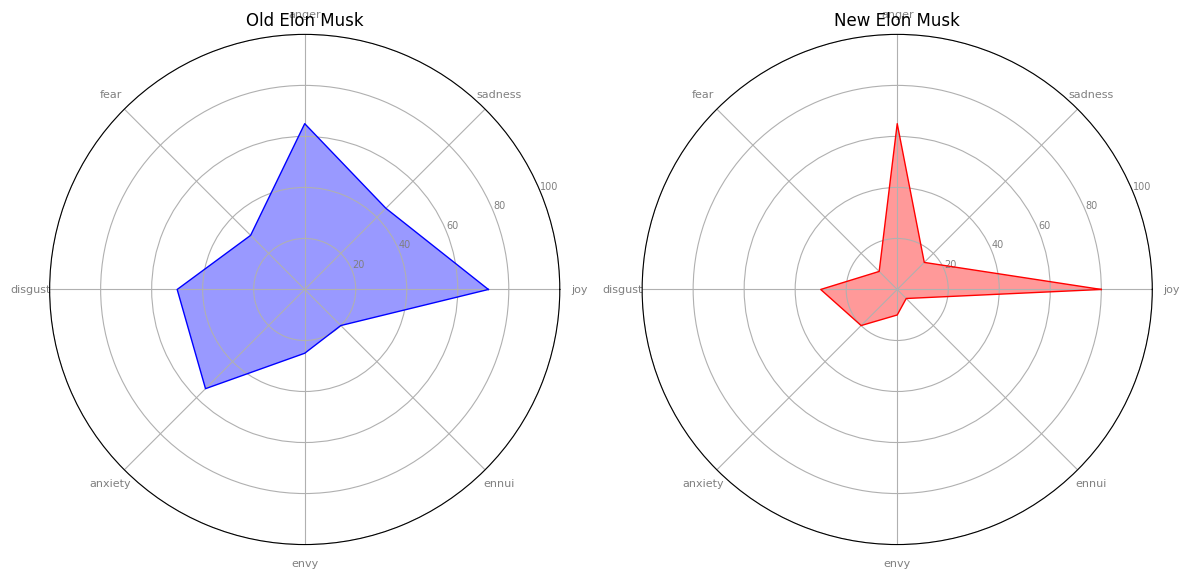

In [22]:
# prompt: make a radar plot of df_sentiment, all columns except "age" are the values in the plot. label each row in the plot by the "age" column. put the plts side by side. have the radius go from 0 to 100. Title the plots "Old Elon Musk" and "New Elon Musk".  old plot = blue and new plot = red

import matplotlib.pyplot as plt
import numpy as np

# Assuming df_sentiment is already loaded as in the provided code.

# Check if required columns exist, handle potential errors gracefully.
required_cols = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'anxiety', 'envy', 'ennui', 'age']
if not all(col in df_sentiment.columns for col in required_cols):
    print("Error: One or more required columns are missing in the DataFrame.")
else:
    categories = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'anxiety', 'envy', 'ennui']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(12, 12))  # Adjust figure size for better side-by-side display

    for i, age in enumerate(['old', 'new']):
        df_age = df_sentiment[df_sentiment['age'] == age]

        # Check if the age group exists
        if not df_age.empty:
            values = df_age.loc[:, categories].values.flatten().tolist()
            values += values[:1]

            ax = plt.subplot(1, 2, i + 1, polar=True)
            plt.xticks(angles[:-1], categories, color='grey', size=8)
            plt.yticks([20, 40, 60, 80, 100], ['20', '40', '60', '80', '100'], color="grey", size=7)
            plt.ylim(0, 100)

            color = 'blue' if age == 'old' else 'red'
            ax.plot(angles, values, linewidth=1, linestyle='solid', color=color)
            ax.fill(angles, values, color, alpha=0.4)

            title = "Old Elon Musk" if age == 'old' else "New Elon Musk"
            plt.title(title)
        else:
            print(f"Warning: No data found for age '{age}'")

    plt.tight_layout()  # Adjust layout for subplots
    plt.show()